# Zillow Clustering Porject

## Project Overview

This final report contains a high-level view into the project process and results, as well as our recommended actions and next phases. For additional insight into the exploration and modeling phase, the two notebooks linked here contain a more in-depth explanation of the process.

## Executive Summary

Goals: Build a new regression model to predict logerror (log(Zestimate) - log(SalePrice)), and after sufficient exploration, these potential drivers would be used as features in predicting the log_error with linear regression algorithms. In attempt to find these drivers, clustering methodologies were used to explore any meaningful groups that are present in the data.

## Process 

Upon successful acquisition of the Zillow data from the Codeup database, it was then transformed into a series of DataFrames which could be used in exploration and model creation. From the initial SQL query, 77,579 properties observations were obtained. This was then filtered to remove any observations that were duplicates of properties sold more than once to retain only the most recent transaction in 2017. Firstly, any variables that was not sufficiently defined, were mislabeled, or were redundant to other columns were dropped. This data was further pared down by removing columns which were missing 25% or more values. Using ±IQR∗3 as upper- and lower-bounds, outliers in the data were removed. Lastly, the data was separated into three dataframes for the train, validate, and test data sets and remove any null values that were in them. This left 62,148 remaining observations, ≈ 80% of the initial observations. From there, any continuous variables were scaled for use clustering and regression modeling before the top performing model was finally put to test on the out-of-sample test data.

## Objectives for this project include:

Identify the drivers for logerrror by using clustering methodologies.

Document the process and analysis throughout the data science pipeline.

Demonstrate the information that was discovered.

In [1]:
#imports
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
import statsmodels.api as sm
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from scipy.stats import f_oneway

import wrangle as w
import explore as e
import model as m

### Wrangling

Acquire Zillow data from Codeup database, and turn it into a .csv for quicker use

In [2]:
#get our data, turn into .csv, and check shape
df = w.get_zillow_data()
df.head()

,parcelid,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,id,basementsqft,...,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc,property_id
0,14297519,NaN,NaN,261.0,NaN,NaN,NaN,NaN,1727539,NaN,...,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN,1727539
1,17052889,NaN,NaN,261.0,NaN,NaN,NaN,NaN,1387261,NaN,...,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN,1387261
2,14186244,NaN,NaN,261.0,NaN,NaN,NaN,NaN,11677,NaN,...,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN,11677
3,12177905,NaN,NaN,261.0,2.0,NaN,NaN,NaN,2288172,NaN,...,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN,2288172
4,10887214,NaN,NaN,266.0,2.0,NaN,NaN,1.0,1970746,NaN,...,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN,1970746


In [3]:
#Check how many missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77579 entries, 0 to 77578
Data columns (total 70 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77579 non-null  int64  
 1   typeconstructiontypeid        223 non-null    float64
 2   storytypeid                   50 non-null     float64
 3   propertylandusetypeid         77579 non-null  float64
 4   heatingorsystemtypeid         49571 non-null  float64
 5   buildingclasstypeid           15 non-null     float64
 6   architecturalstyletypeid      207 non-null    float64
 7   airconditioningtypeid         25007 non-null  float64
 8   id                            77579 non-null  int64  
 9   basementsqft                  50 non-null     float64
 10  bathroomcnt                   77579 non-null  float64
 11  bedroomcnt                    77579 non-null  float64
 12  buildingqualitytypeid         49809 non-null  float64
 13  c

Takeaways:

Lots of missing values Some columns have inaccurate content? Let's just clean it up for now, and we'll decide what we want to explore on later

Prepare our data for mostly-ready use. We're going to rename columns, make dummies, create new features, drop outliers, and drop columns and rows with more than 50% missing values.

In [4]:
#Clean zillow and then look at the df once again
df = w.prepare_zillow(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62235 entries, 0 to 77578
Data columns (total 46 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   parcel_id                   62235 non-null  int64  
 1   propertylandusetypeid       62235 non-null  float64
 2   id                          62235 non-null  int64  
 3   baths                       62235 non-null  float64
 4   beds                        62235 non-null  float64
 5   calculatedbathnbr           62221 non-null  float64
 6   sqft                        62235 non-null  float64
 7   finishedsquarefeet12        62069 non-null  float64
 8   fullbathcnt                 62221 non-null  float64
 9   latitude                    62235 non-null  float64
 10  longitude                   62235 non-null  float64
 11  lotsizesquarefeet           62235 non-null  float64
 12  propertycountylandusecode   62235 non-null  object 
 13  rawcensustractandblock      622

In [5]:
#split into train, validate, test. Our target is logerror
train, validate, test = w.train_validate_test_split(df, 'logerror', seed=1234)

In [6]:
#imputation preserves all cases by replacing missing data with an estimated value 
#based on other available information
#return our train, validate, and test sets with calculatedbathnbr, fullbathcnt, regionidcity, regionidzip,censustractandblock
#imputed with most frequent values
train, validate, test = w.impute_nulls(train, validate, test, strategy='most_frequent', 
                        col_list=['calculatedbathnbr', 'fullbathcnt', 'regionidcity', 'regionidzip', 'censustractandblock'])

In [7]:
#return our train, validate, and test sets with finishedsquarefeet12, lotsizesquarefeet, structuretaxvaluedollarcnt, 
#tax_value, land tax value dollar count, and tax amount imputed with the column's median value. 
train, validate, test = w.impute_nulls(train, validate, test, strategy='median', 
                        col_list=['finishedsquarefeet12', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 
                                  'tax_value', 'landtaxvaluedollarcnt', 'tax_amount'])

In [8]:
#checking there are no more nulls in train valdiate and test
train.isna().sum().sum(), validate.isna().sum().sum(), test.isna().sum().sum()

(88, 39, 21)

In [9]:
#drop rows with remaining nulls from all of our split sets
train = train.dropna()
validate = validate.dropna()
test = test.dropna()

In [10]:
#assuring there are no more nulls and we can almost get to work
train.isna().sum().sum(), validate.isna().sum().sum(), test.isna().sum().sum()

(0, 0, 0)

In [11]:
#total rows and columns that are left to work with 
#train should have most dataset
#47 columns in each dataset
train.shape, validate.shape, test.shape

((34798, 46), (14915, 46), (12435, 46))

In [12]:
34798+ 14915 + 12435

62148

In [13]:
#split new train, validate, and test into X_train, y_train, X_validate, y_validate, X_test, y_test with logerror as our target
X_train, y_train, X_validate, y_validate, X_test, y_test = w.split_X_y(train, validate, test, 'logerror')

Wrangle Takeaways:

- Our data is now clean, and split into train, validate and test.
- We dropped any rows and columns with more than 50% missing values 
- Dropped, filled, or imputed for remaining missing values 
- We went from 77,575 rows to 49,727rows. At the start, we had 68 columns, after the data is cleaned, now 47 columns.

### Explore

Now that data preparation is complete, it can be obtained using a function that performs all of the steps taken to ready it for exploration. All exploration will occur on the train split, and attempts to glean any meaningful relationships will be made. Using Pearsonr and t-test to find correlation coefficients or any difference with log error, a heat map of variables to the target will be made to find any obvious material associations. For a more in-depth look into this and the preceding process, please see the first_workbook.ipynb notebook.

**Hypothesis List**

1.) Log error is affected by square footage, number of bedrooms and bathrooms.

2.) Log error is affected by property age

3.) Log error is affected by location

4.) Log error is affected by price per sq ft.

5.) Log error is affected by different counties

### Univariate Explore

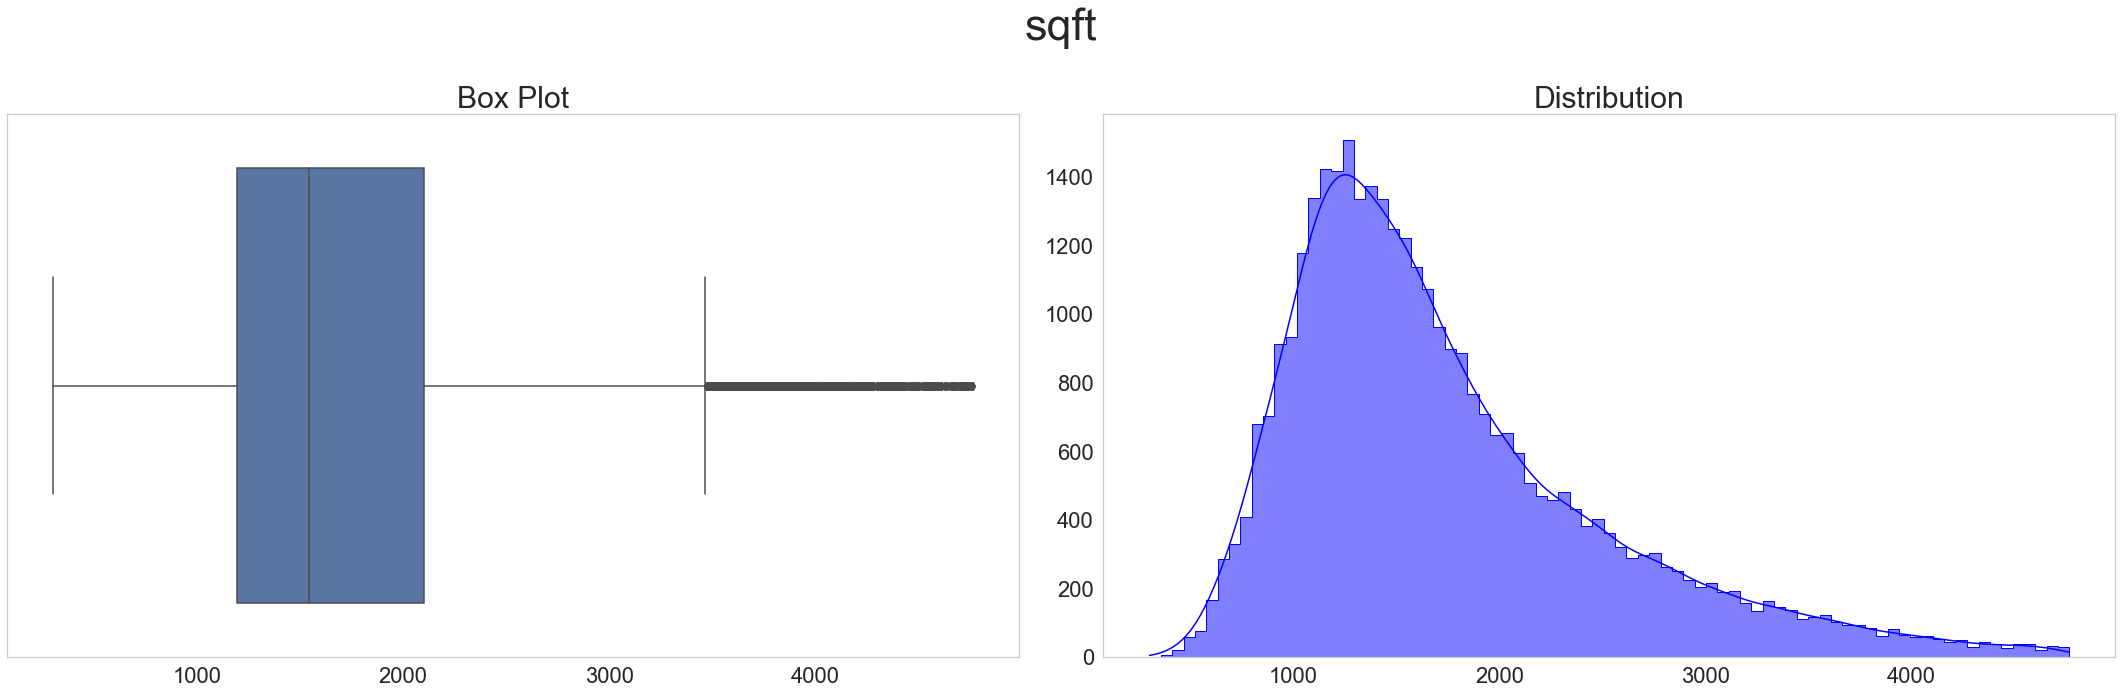

Summary Statistics for sqft
count    34798.000000
mean      1740.608225
std        775.299846
min        300.000000
25%       1191.000000
50%       1544.000000
75%       2102.000000
max       4768.000000
Name: sqft, dtype: float64


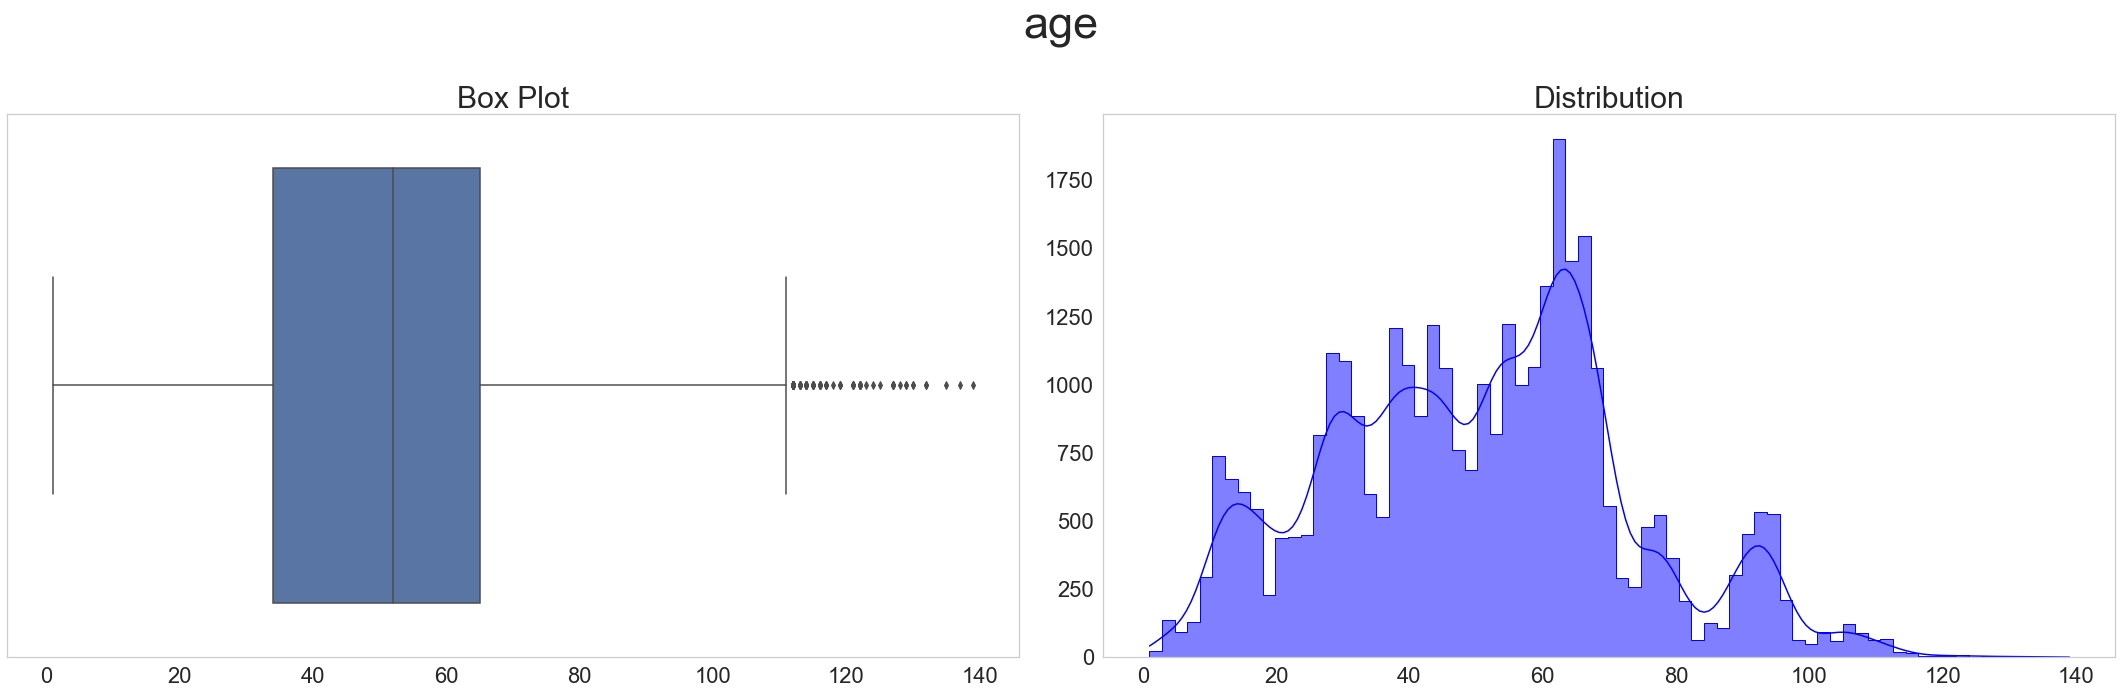

Summary Statistics for age
count    34798.000000
mean        50.649836
std         22.561923
min          1.000000
25%         34.000000
50%         52.000000
75%         65.000000
max        139.000000
Name: age, dtype: float64


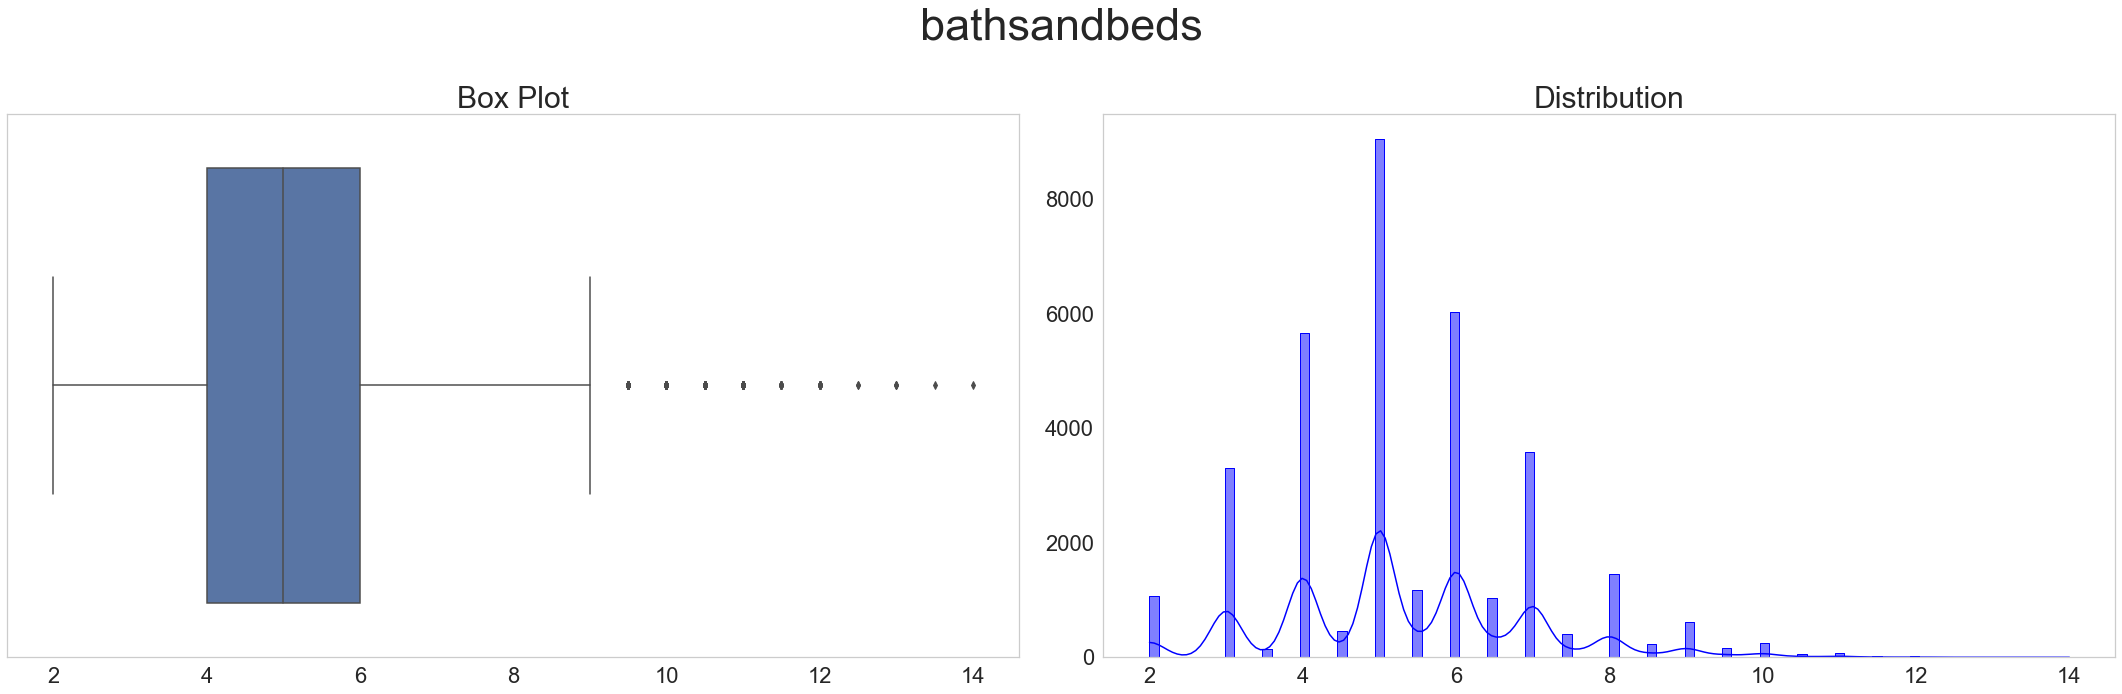

Summary Statistics for bathsandbeds
count    34798.000000
mean         5.316843
std          1.629526
min          2.000000
25%          4.000000
50%          5.000000
75%          6.000000
max         14.000000
Name: bathsandbeds, dtype: float64


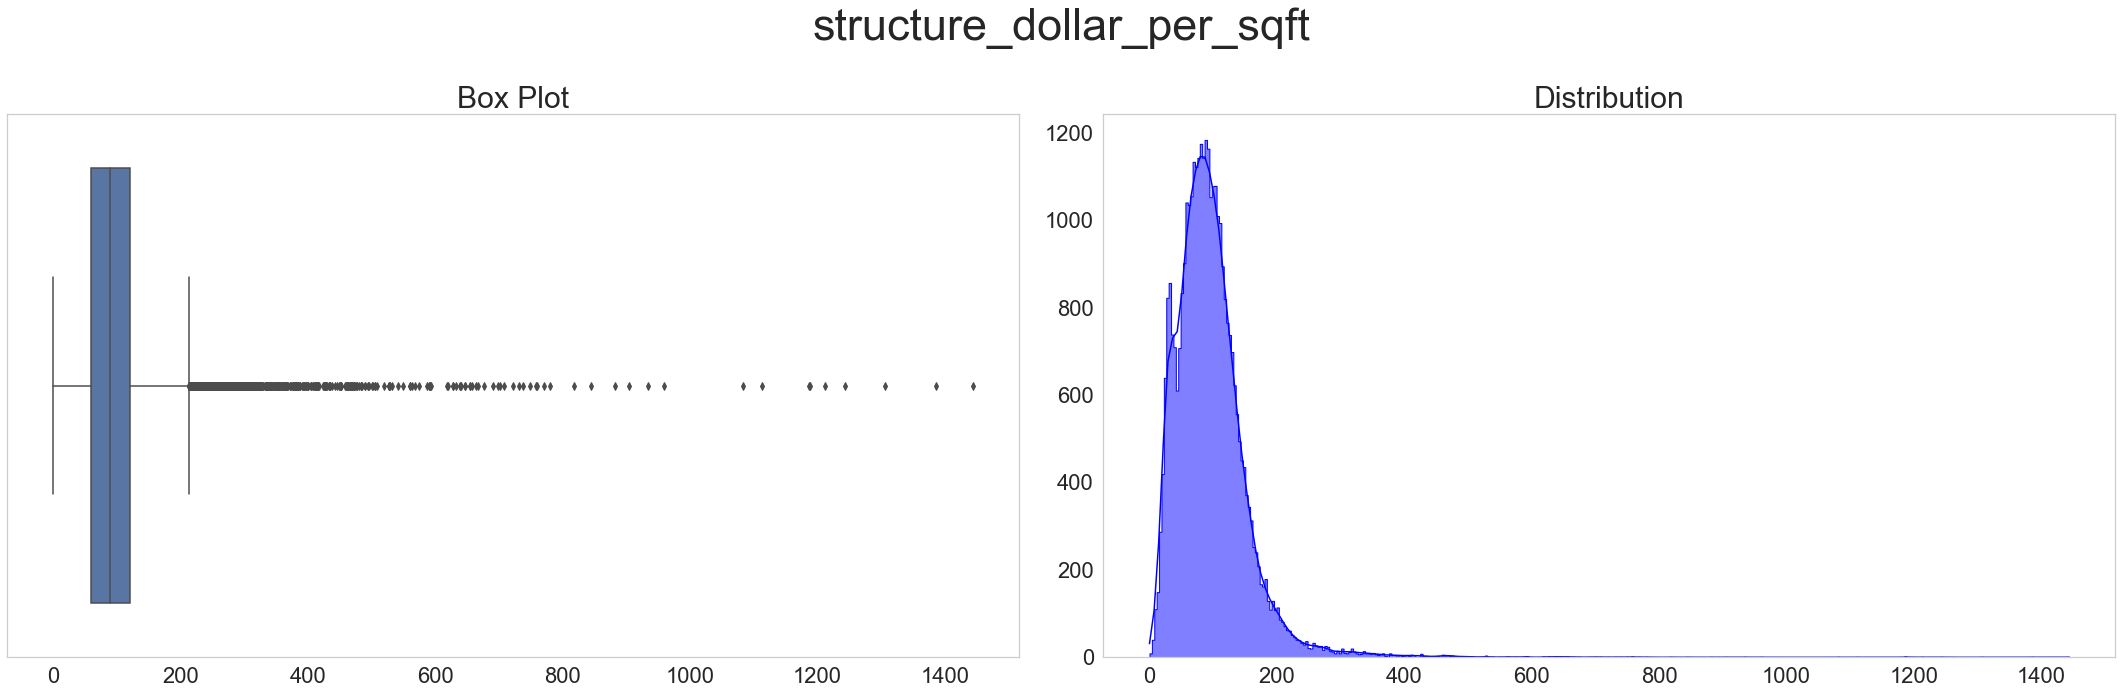

Summary Statistics for structure_dollar_per_sqft
count    34798.000000
mean        96.702800
std         61.204865
min          0.039833
25%         59.616943
50%         88.914182
75%        121.153213
max       1444.221106
Name: structure_dollar_per_sqft, dtype: float64


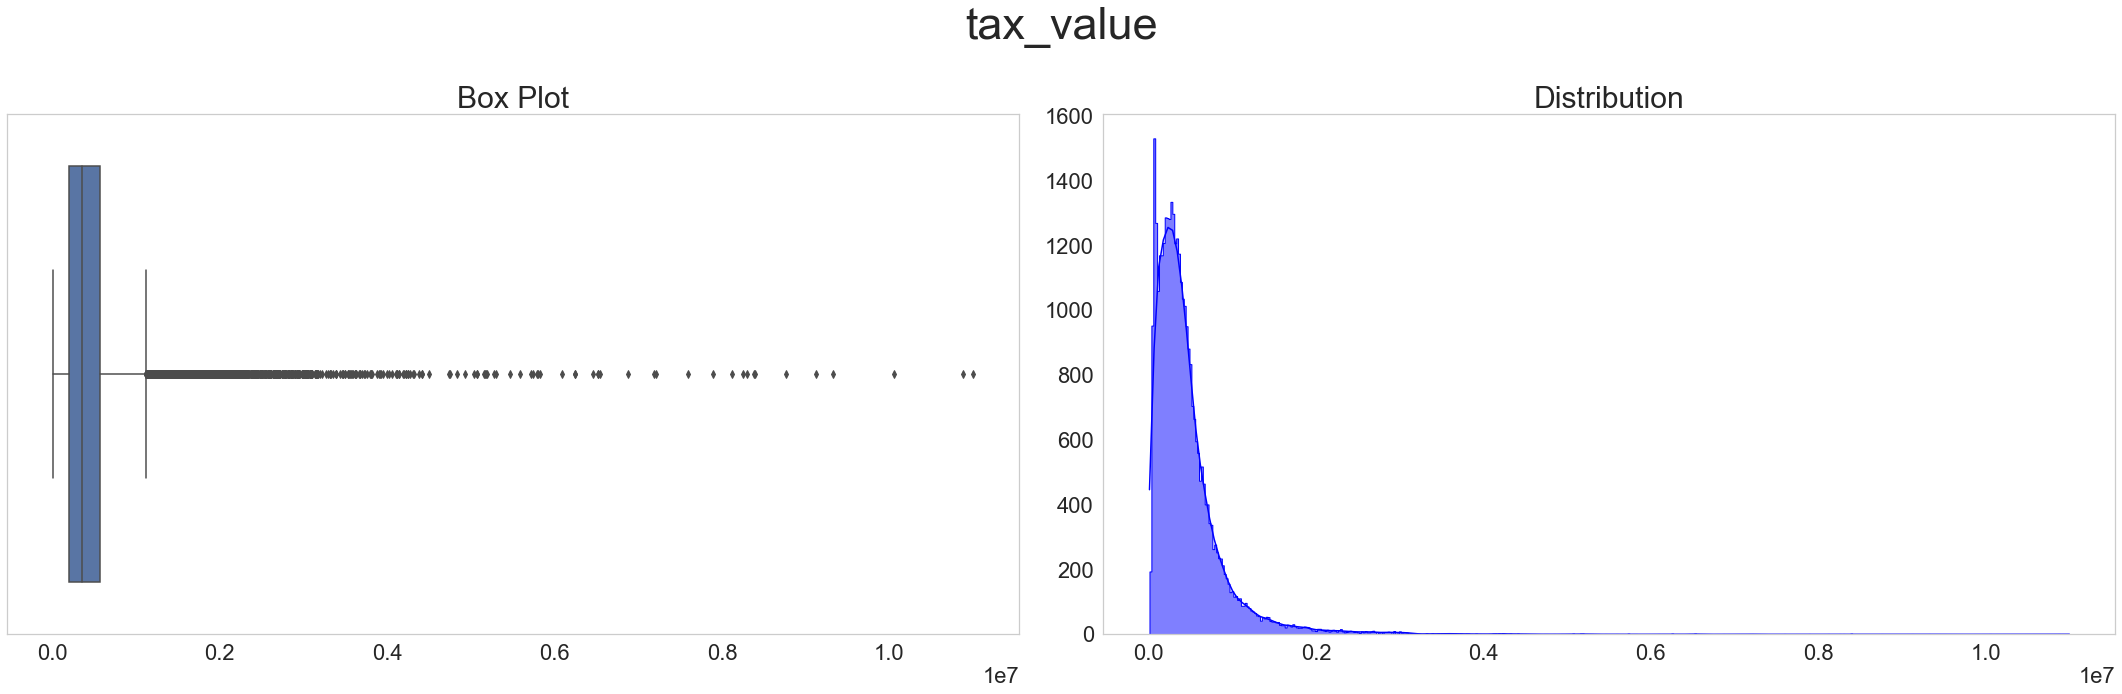

Summary Statistics for tax_value
count    3.479800e+04
mean     4.617809e+05
std      4.795004e+05
min      1.050400e+04
25%      1.954202e+05
50%      3.502830e+05
75%      5.670938e+05
max      1.100000e+07
Name: tax_value, dtype: float64


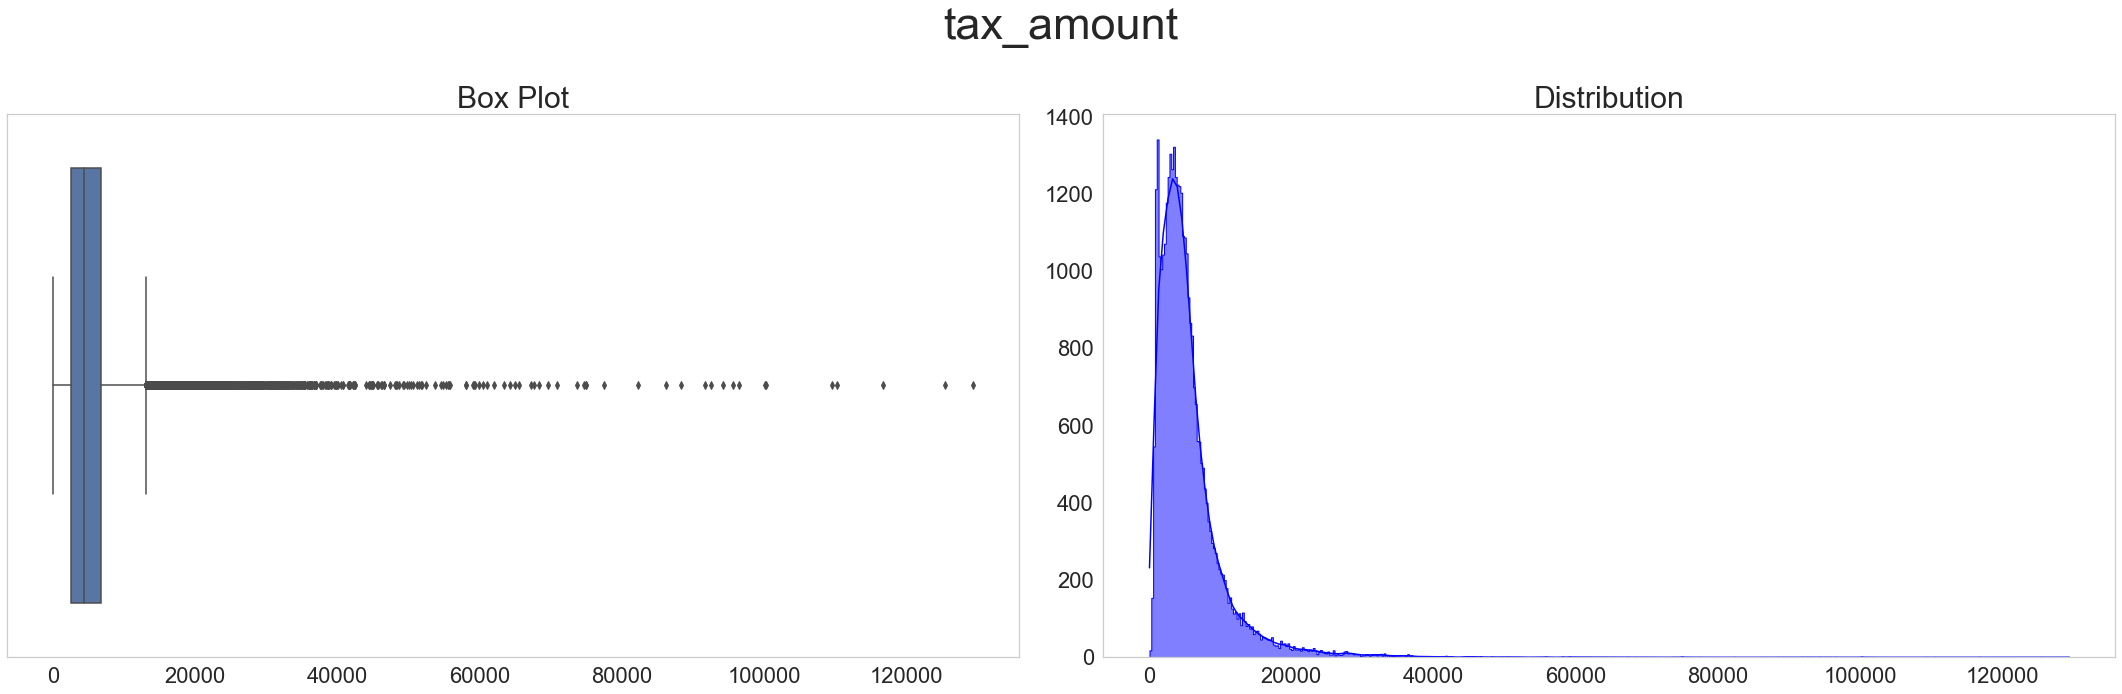

Summary Statistics for tax_amount
count     34798.000000
mean       5651.788221
std        5547.630025
min          49.180000
25%        2620.350000
50%        4376.995000
75%        6785.635000
max      129365.370000
Name: tax_amount, dtype: float64


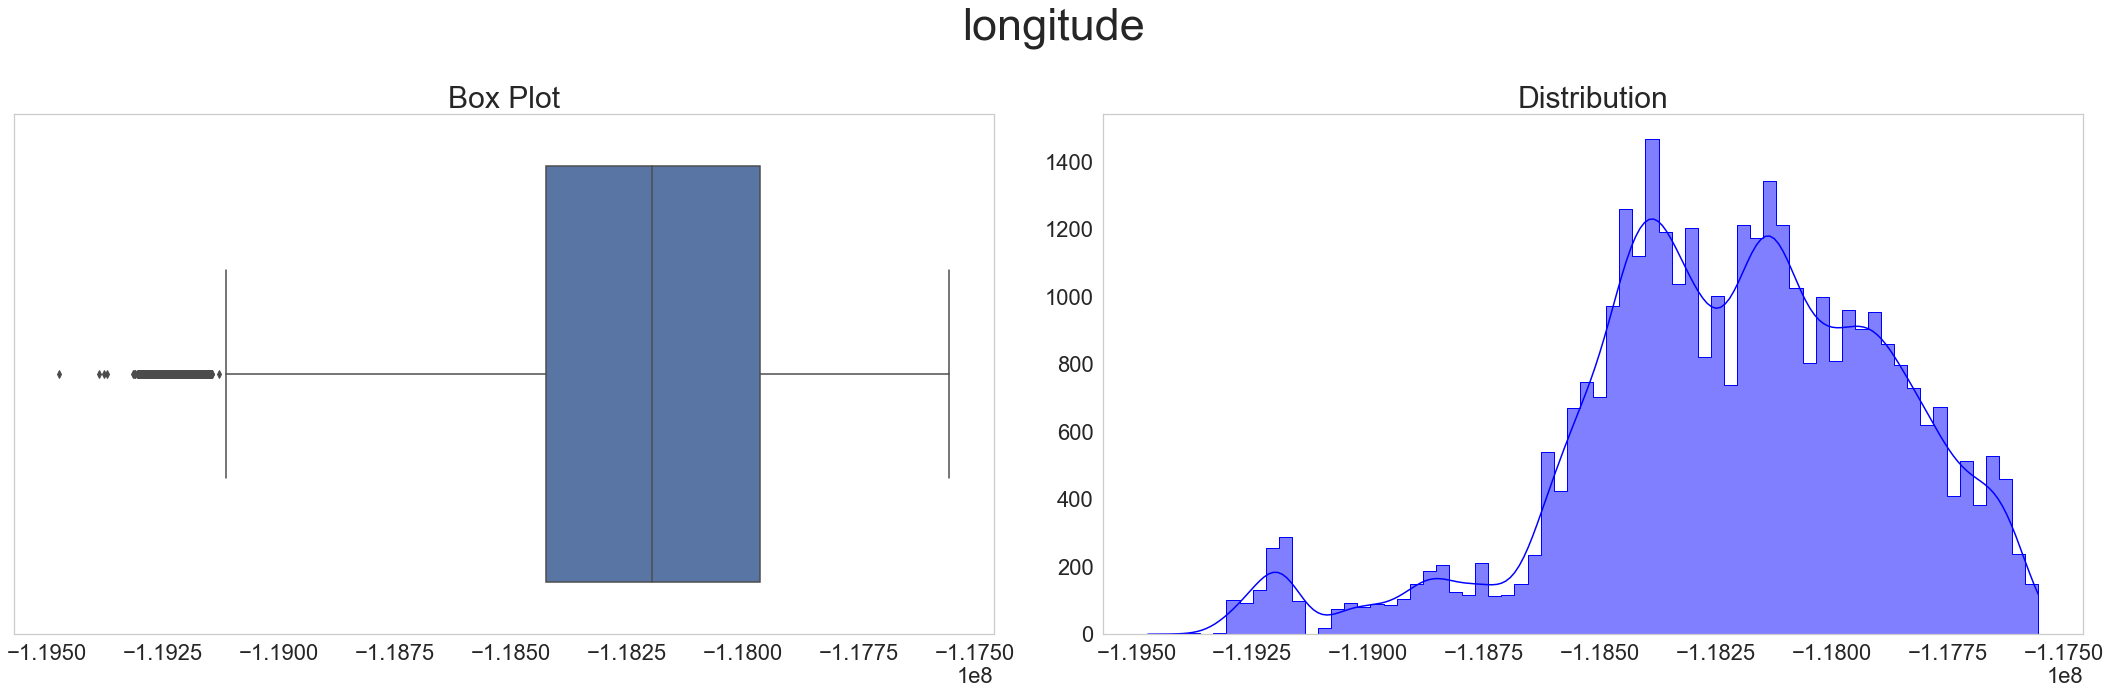

Summary Statistics for longitude
count    3.479800e+04
mean    -1.182196e+08
std      3.465018e+05
min     -1.194753e+08
25%     -1.184244e+08
50%     -1.181951e+08
75%     -1.179632e+08
max     -1.175546e+08
Name: longitude, dtype: float64


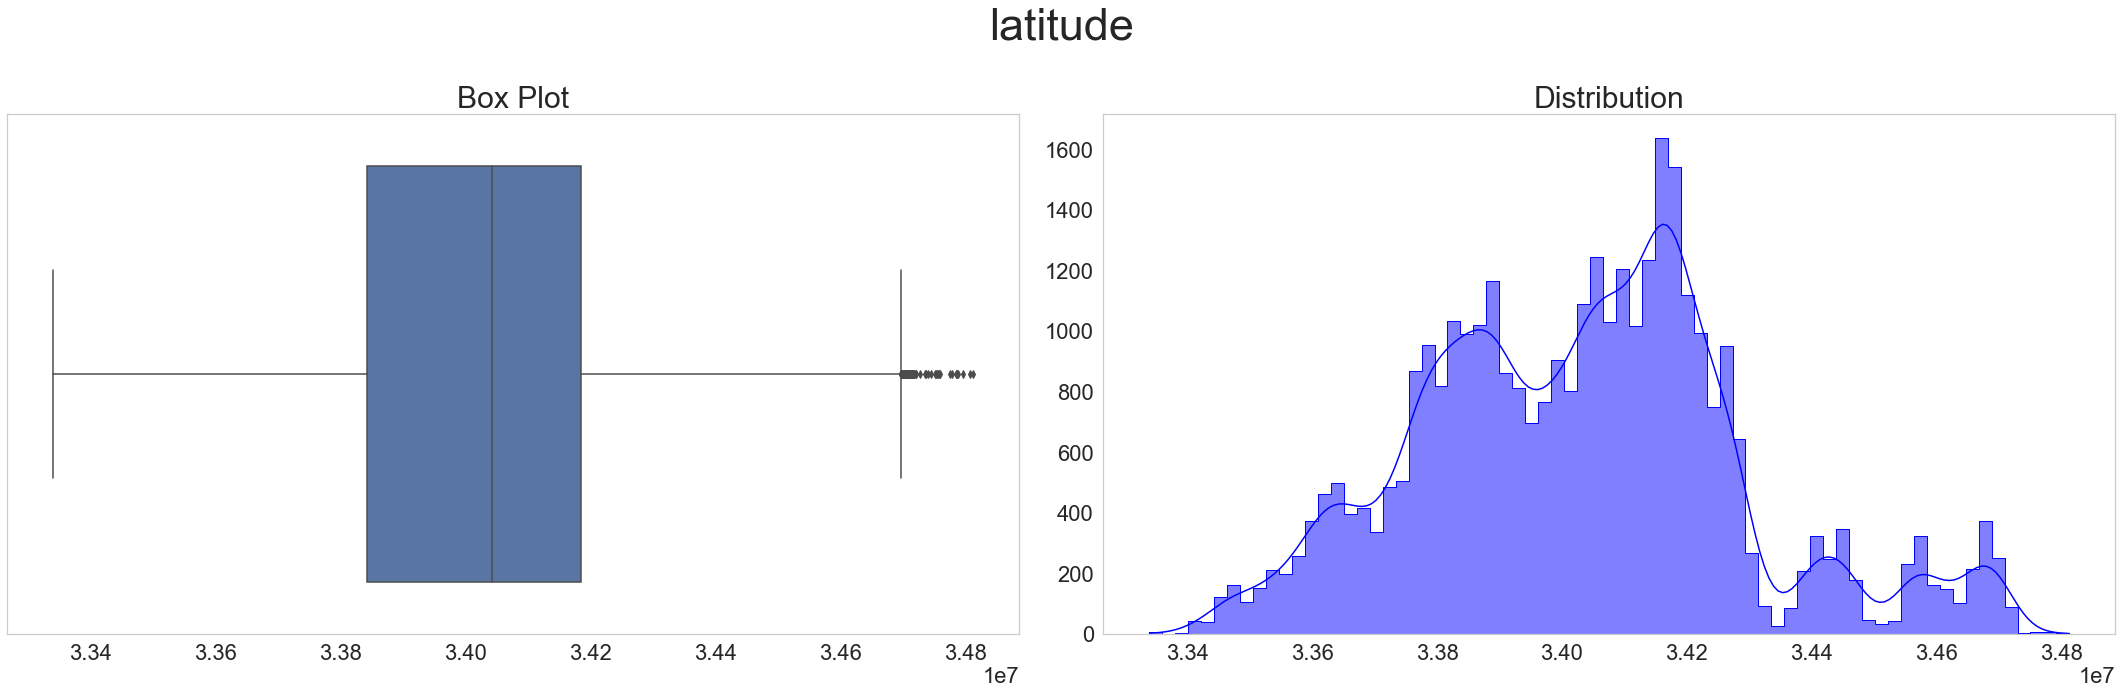

Summary Statistics for latitude
count    3.479800e+04
mean     3.403071e+07
std      2.617833e+05
min      3.333960e+07
25%      3.384162e+07
50%      3.404170e+07
75%      3.418393e+07
max      3.481240e+07
Name: latitude, dtype: float64


In [14]:
univariate_e = ['sqft','age','bathsandbeds','structure_dollar_per_sqft','tax_value','tax_amount', 'longitude','latitude']

for i in univariate_e:
    e.explore_univariate(train, i)
    print(f'Summary Statistics for {i}\n{train[i].describe()}')

**Takeaways:**

- Normal: number of bathrooms and bedrooms (bathsandeds), latitude, and age
- Skewed right: tax amount, tax value, price per sqft
- Skewed left: longitude

### Bivariate Exploration

#### Does log error affect by different counties?

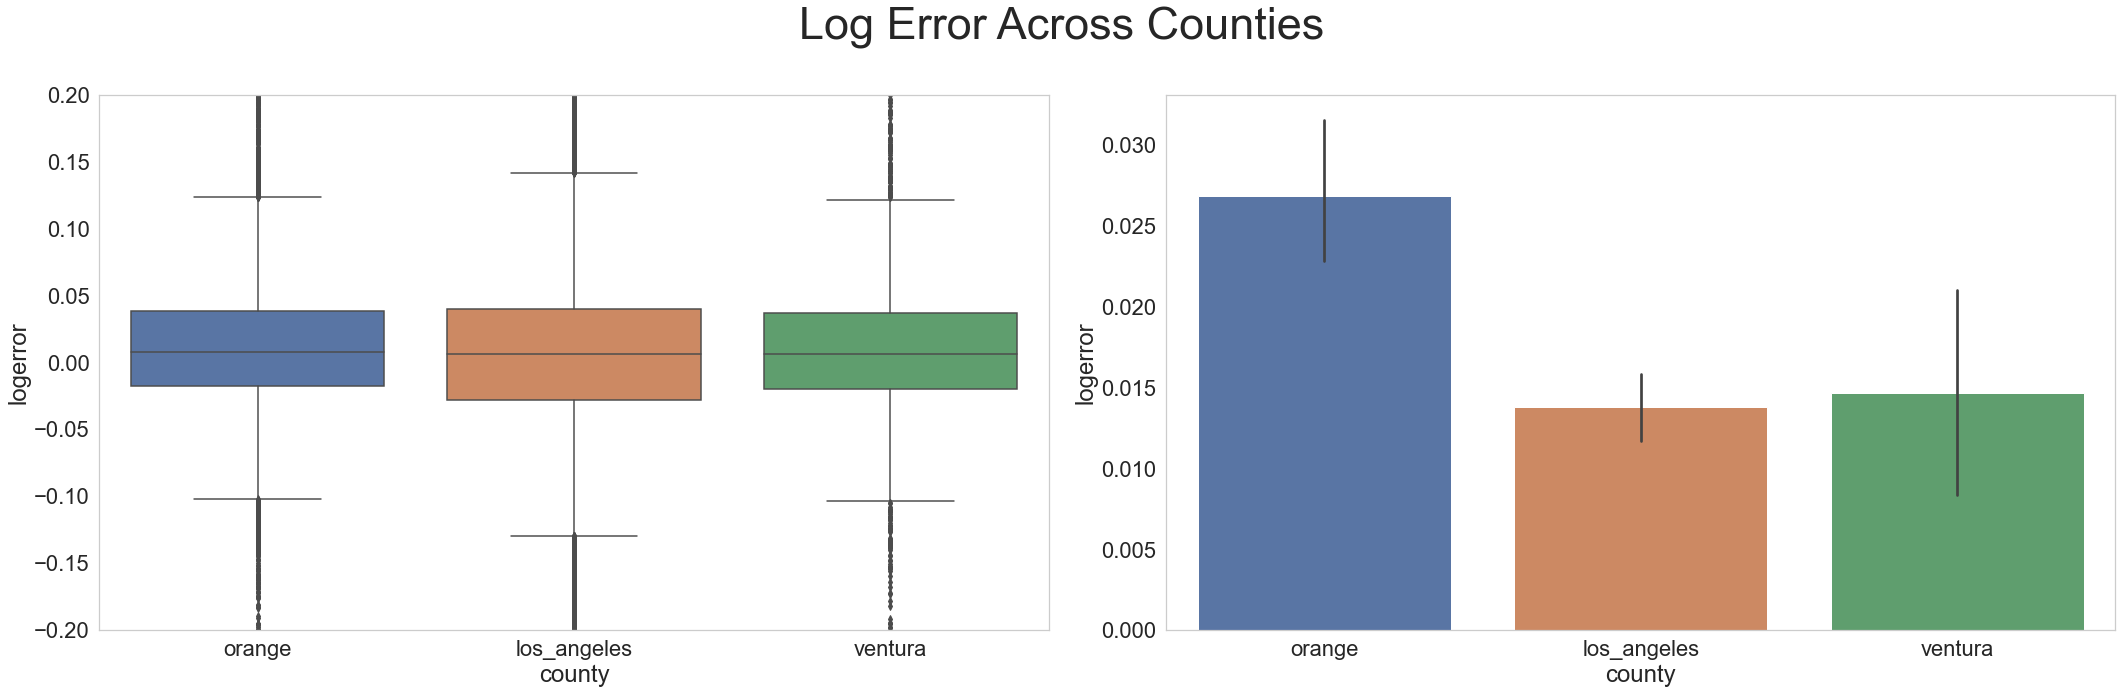

In [15]:
#logerror across counties (LA, Orange, and Ventura)

#set up figure size, font size, and turn off grid.
plt.figure(figsize=(30,10))
sns.set(font_scale = 2)
sns.set_style("whitegrid", {'axes.grid' : False})

#boxplot
plt.subplot(1, 2, 1)
sns.boxplot(train.county, train.logerror)
plt.ylim(-.2, .2)

#barplot
plt.subplot(1, 2, 2)
sns.barplot(data=train, x='county',y='logerror')

#title
plt.suptitle('Log Error Across Counties', fontsize = 45)
plt.tight_layout()
plt.show()

In [16]:
#T-test between orange county and other county
null_hypothesis = "no difference in logerror between orange county and the other counties"
alternative_hypothesis = "there is a difference in log error between orange county and other counties"
a = 0.05 #a for alpha 

orange_logerror=train[train.county=='orange'].logerror
other_logerror = train[train.county!='orange'].logerror
t, p = stats.ttest_ind(orange_logerror, other_logerror)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: no difference in logerror between orange county and the other counties
There is evidence to suggest: there is a difference in log error between orange county and other counties


#### Does log error affect by property age?

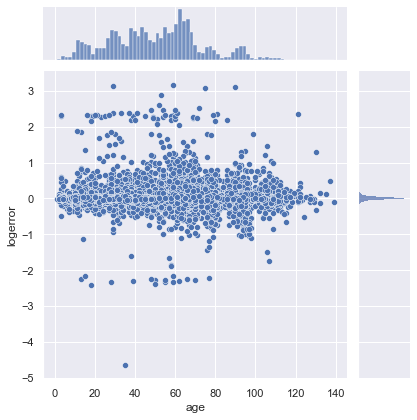

In [63]:
#Property age and log error
sns.jointplot(x='age', y='logerror', data=train)
plt.xlabel('Age')
plt.ylabel('Log Error')
plt.show()

In [18]:
#Correlation test between property age vs logerror
null_hypothesis = "no evident correlation logerror between property age"
alternative_hypothesis = "there is evident correlation between log error and property age"
a = 0.05 #a for alpha 

corr, p = stats.pearsonr(train.age,train.logerror)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: no evident correlation logerror between property age
There is evidence to suggest: there is evident correlation between log error and property age


#### Does logerror affect by price per sqft?

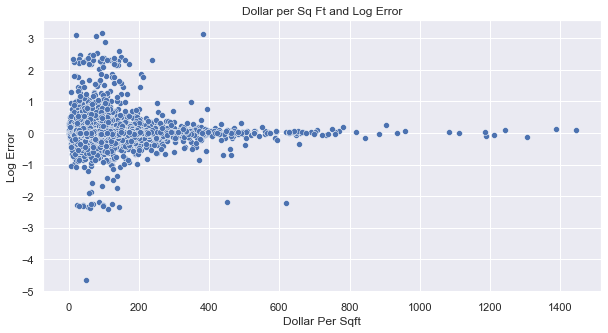

In [64]:
 #Dollar/Sqft and Log Error
plt.figure(figsize=(10,5))
sns.scatterplot(x='structure_dollar_per_sqft', y='logerror', data=train)
plt.xlabel('Dollar Per Sqft')
plt.ylabel('Log Error')
plt.title('Dollar per Sq Ft and Log Error')
plt.show()

In [20]:
#Correlation test between logerror and structure_dollar_per_sqft
null_hypothesis = "no evident correlation logerror between dollar per sqft"
alternative_hypothesis = "there is evident correlation between log error and dollar per sqft"
a = 0.05 #a for alpha 

corr, p = stats.pearsonr(train.structure_dollar_per_sqft,train.logerror)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: no evident correlation logerror between dollar per sqft
There is evidence to suggest: there is evident correlation between log error and dollar per sqft


### Multivariate Exploration

In [65]:
#let's add log error bins
train['logerror_bins'] = pd.cut(train.logerror, [-5, -.2, -.05, .05, .2, 4])

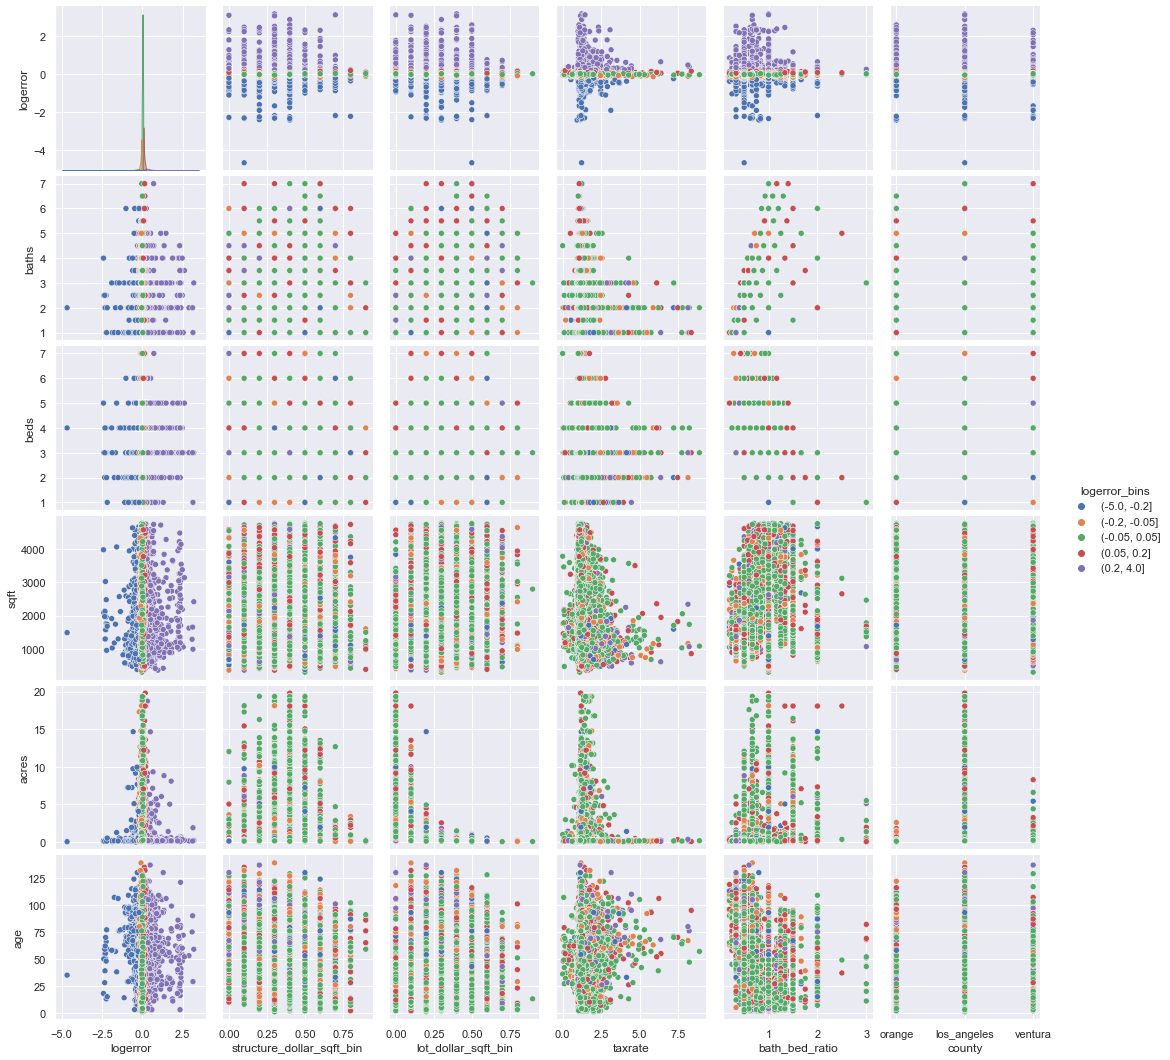

In [66]:
#the pairplot
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['logerror','structure_dollar_sqft_bin', 'lot_dollar_sqft_bin', 
                       'taxrate', 'bath_bed_ratio','county'],
             y_vars = ['logerror', 'baths','beds', 'sqft', 'acres', 'age'])

<AxesSubplot:title={'center':'Feautures Correlating with Value'}>

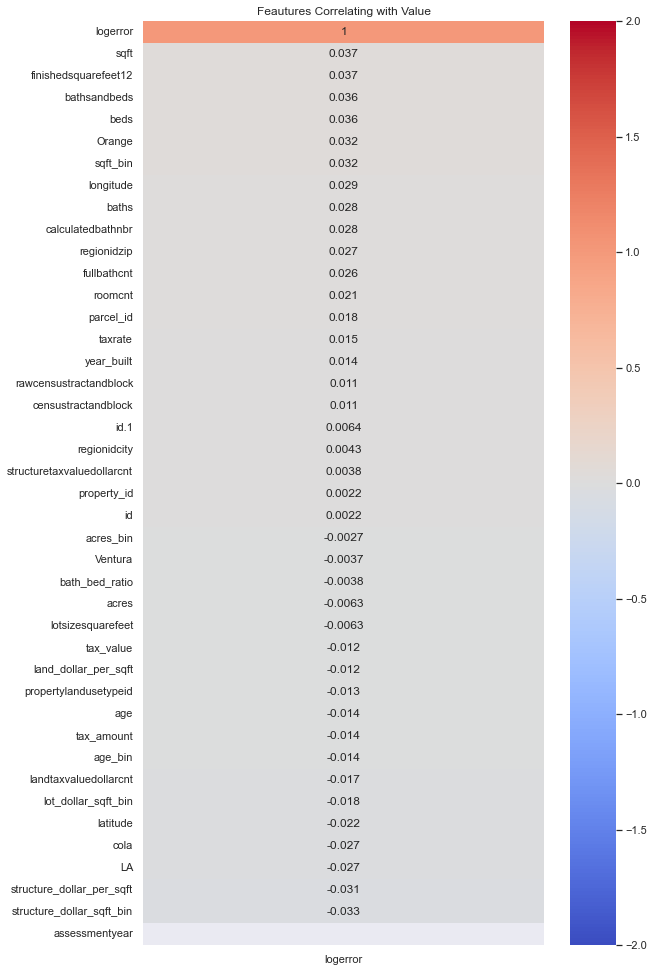

In [23]:
#let's focus on my target to see any correlate with the target
e.get_zillow_heatmap(train,'logerror')

**Takeaway:**

- logerror does not correlate well with any features

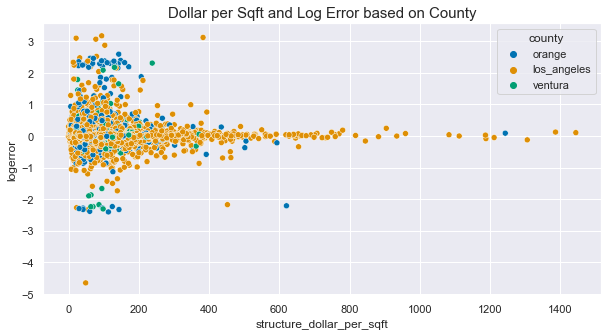

In [24]:
#Dollar per sqft vs logerror based on county
plt.figure(figsize=(10,5))
sns.scatterplot(x='structure_dollar_per_sqft',y='logerror',data=train,hue='county', palette='colorblind')
plt.title('Dollar per Sqft and Log Error based on County', fontsize=15)
plt.show()

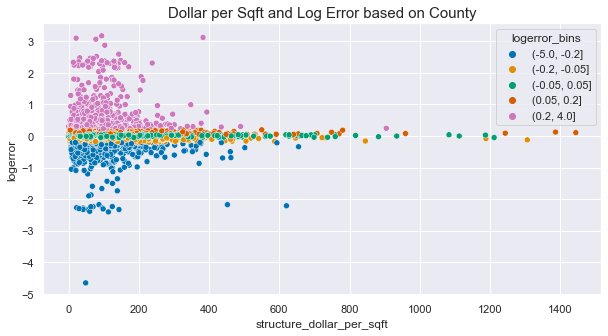

In [25]:
#Same above but using the log error bins
plt.figure(figsize=(10,5))
sns.scatterplot(x='structure_dollar_per_sqft',y='logerror',data=train,hue='logerror_bins', palette='colorblind')
plt.title('Dollar per Sqft and Log Error based on County', fontsize=15)
plt.show()

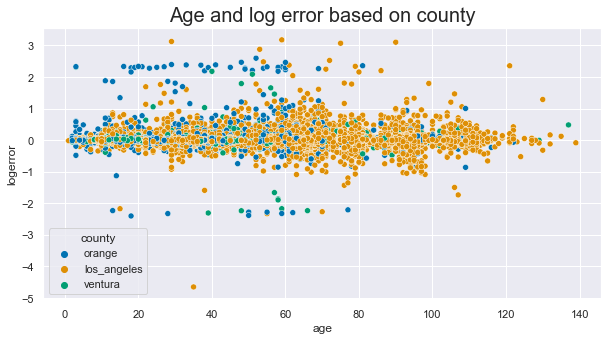

In [26]:
#Age vs log error base on county
plt.figure(figsize=(10,5))
sns.scatterplot(x='age',y='logerror',data=train,hue='county', palette='colorblind')
plt.title('Age and log error based on county', fontsize=20)
plt.show()

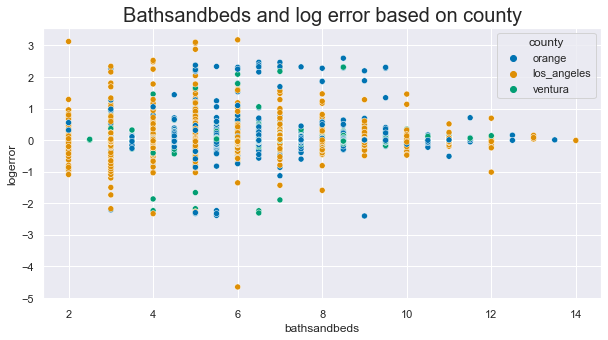

In [27]:
#Bathsandbeds vs log error base on county
plt.figure(figsize=(10,5))
sns.scatterplot(x='bathsandbeds',y='logerror',data=train,hue='county', palette='colorblind')
plt.title('Bathsandbeds and log error based on county', fontsize=20)
plt.show()

In [28]:
#Main purpose of logerror_bins is for exploration, other than that just drop the columns
train = train.drop(columns=['logerror_bins'])

**Exploration Takeaways:**

- Log error is affected by property age, price per square foot, number of bedrooms, and number of bathrooms.
- More variance in log error with cheaper houses
- Visually appears that Orange county has the most variance in log error
- Heatmap suggests none of the features (on their own) are strongly correlated to logerror.
- Let's move on to clustering

### Data explore with clusters

In this section, several clusters are created to try and discern potential groupings with significantly difference variances in log_error between those populations. The number of clusters was determined using the elbow plot method to find when change in inertia to k has dropped relative to lower k values. For more information, check out my elbow_chart function in explore.py or my first_workbook.ipynb

Using analysis of variance (ANOVA) test, those clusters that can reject the respective null hypothesis will be carried into potential model features.

#### Hypotheses and Significance Level

H0: There is no significant difference in log_error between cluster groups for structure_square_feet, and age.

Ha: There is a significant difference in log_error between cluster groups for structure_square_feet and age.

In [29]:
#Significance Level
α = 0.05

Clusters based on age property and square footage


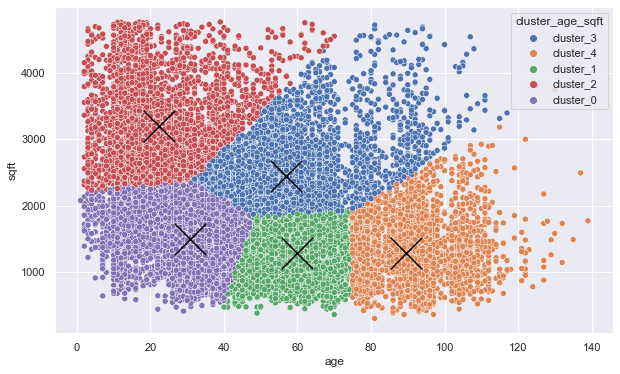

In [30]:
#Let's look at property age and square footage
X_features = ['age', 'sqft']
train, X_scaled, scaler, kmeans, centroids = e.create_cluster(train, validate, test, X_features, 5,'cluster_age_sqft')
e.create_scatter_plot('age','sqft',train,kmeans, X_scaled, scaler,'cluster_age_sqft')
print('Clusters based on age property and square footage')

In [31]:
agescluster_0=train[train.cluster_age_sqft == 'cluster_0'].logerror
agescluster_1=train[train.cluster_age_sqft == 'cluster_1'].logerror
agescluster_2=train[train.cluster_age_sqft == 'cluster_2'].logerror
agescluster_3=train[train.cluster_age_sqft == 'cluster_3'].logerror
agescluster_4=train[train.cluster_age_sqft == 'cluster_4'].logerror 

In [32]:
#Statistically significant differences in log error means between these groups? 
f, p = f_oneway(agescluster_0,agescluster_1,agescluster_2,agescluster_3,agescluster_4)
f,p

(13.989779044024642, 2.088389825174118e-11)

In [33]:
if p < α:
    print(f'Reject null hypothesis')
else:
    print(f'Fail to reject null hypothesis')

Reject null hypothesis


H0: There is no significant difference in log_error between cluster groups for latitude and longitude.

Ha: There is a significant difference in log_error between cluster groups for latitude and longitude.

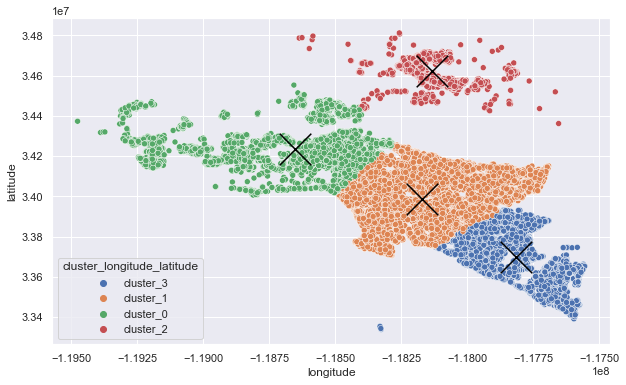

In [34]:
#Let's look at longitude and latitude
#selecting the features we want to cluster on
X_features2 = ['longitude', 'latitude',]
train, X_scaled, scaler, kmeans, centroids = e.create_cluster(train,validate,test, X_features2, 4,'cluster_longitude_latitude')
e.create_scatter_plot('longitude','latitude',train,kmeans, X_scaled, scaler,'cluster_longitude_latitude')

In [35]:
#Give a variable name for each clusters
l_cluster_0 = train[train.cluster_longitude_latitude == 'cluster_0'].logerror
l_cluster_1 = train[train.cluster_longitude_latitude == 'cluster_1'].logerror
l_cluster_2 = train[train.cluster_longitude_latitude == 'cluster_2'].logerror
l_cluster_3 = train[train.cluster_longitude_latitude == 'cluster_3'].logerror

In [36]:
#Statistically significant differences in log error means between these groups? 
f, p = f_oneway(l_cluster_0,l_cluster_1,l_cluster_2, l_cluster_3)
f, p

(12.615107301029763, 3.077723139241813e-08)

In [37]:
if p < α:
    print(f'Reject null hypothesis')
else:
    print(f'Fail to reject null hypothesis')

Reject null hypothesis


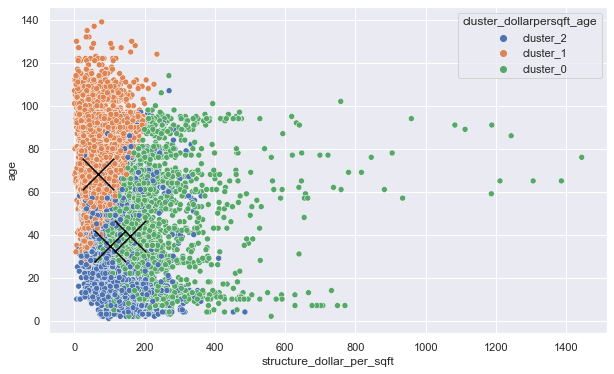

In [38]:
#Let's look at sqft and bathsandbeds
#selecting the features we want to cluster on
X_features3 = ['age','bathsandbeds','structure_dollar_per_sqft']
train, X_scaled, scaler, kmeans, centroids = e.create_cluster(train,validate,test, X_features3, 3,'cluster_dollarpersqft_age')
e.create_scatter_plot('structure_dollar_per_sqft','age',train,kmeans, X_scaled, scaler,'cluster_dollarpersqft_age')

In [39]:
#Give a variable name for each clusters
dollarsqfta_cluster_0 = train[train.cluster_dollarpersqft_age == 'cluster_0'].logerror
dollarsqfta_cluster_1 = train[train.cluster_dollarpersqft_age == 'cluster_1'].logerror
dollarsqfta_cluster_2 = train[train.cluster_dollarpersqft_age == 'cluster_2'].logerror

In [40]:
#Statistically significant differences in log error means between these groups? 
f, p = f_oneway(dollarsqfta_cluster_0,dollarsqfta_cluster_1,dollarsqfta_cluster_2)
f, p

(19.881966656210494, 2.3458578309450068e-09)

In [41]:
if p < α:
    print(f'Reject null hypothesis')
else:
    print(f'Fail to reject null hypothesis')

Reject null hypothesis


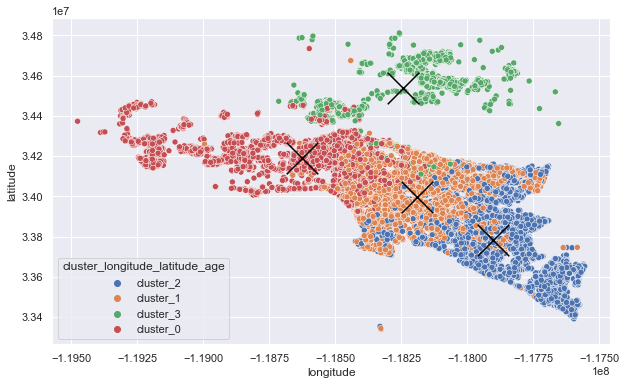

In [42]:
#Let's look at sqft and bathsandbeds
X_features4 = ['longitude','latitude','age']
train, X_scaled, scaler, kmeans, centroids = e.create_cluster(train,validate,test, X_features4, 4,'cluster_longitude_latitude_age')
e.create_scatter_plot('longitude','latitude',train,kmeans, X_scaled, scaler,'cluster_longitude_latitude_age')

In [43]:
#Give a variable name for each clusters
lacluster_0=train[train.cluster_longitude_latitude_age == 'cluster_0'].logerror
lacluster_1=train[train.cluster_longitude_latitude_age == 'cluster_1'].logerror
lacluster_2=train[train.cluster_longitude_latitude_age == 'cluster_2'].logerror
lacluster_3=train[train.cluster_longitude_latitude_age == 'cluster_3'].logerror

In [44]:
#Statistically significant differences in log error means between these groups? 
f, p = f_oneway(lacluster_0,lacluster_1,lacluster_2, lacluster_3)
f, p

(9.68825855999723, 2.182666792697333e-06)

In [45]:
if p < α:
    print(f'Reject null hypothesis')
else:
    print(f'Fail to reject null hypothesis')

Reject null hypothesis


### Modeling

- Scale our train, validate and test into X_train, X_validate and X_test with minmaxscaler, we are not scale our target variable
- Put target variable (log error) into a dataframe
- Use the scale dataset to create, fit and use the model
- Use rfe to select our features to use for models, since rfe fits mulitple models and figures out what the most impactful features are based on the model and drop the least impact features
- Create a baseline by select the one has lowest RMSE between the mean and median
- Select the model base on the feature selected from rfe, the one has lowest rmse in validate and highest r square score
- Test our best model on unseen data which is X_test and then compare it to the baseline

I choose RMSE and R-Squared as my metric because it is the easiest to interpret since it is expressed in units that are equivalent to our target variable and indicates the percentage of the variance in the dependent variable that the independent variables explain collectively. The RMSE tells us the standard deviation of the difference between our predictions and the actual values and therefore gives us an idea of how spread out the actual data points are around our regression line.

In [46]:
#create a list of columns
list_cluster = train.columns.to_list()
#get only clusters columns
cat_var = list_cluster[-4:]

In [47]:
#Create dummies for our clusters
#train
dummies =  pd.get_dummies(train[cat_var])
train = pd.concat([train, dummies], axis=1)
train = train.drop(columns=cat_var)

#validate
dummies =  pd.get_dummies(validate[cat_var])
validate = pd.concat([validate, dummies], axis=1)
validate = validate.drop(columns=cat_var)

#test
dummies =  pd.get_dummies(test[cat_var])
test = pd.concat([test, dummies], axis=1)
test = test.drop(columns=cat_var)

In [48]:
#new X_train, y_train, X_validate, y_validate, X_test, y_test
X_train, y_train, X_validate, y_validate, X_test, y_test = w.split_X_y(train, validate, test, 'logerror')

In [49]:
#get object columns, and numeric columns. Using numeric columns to scale.
obj_cols = w.get_object_cols(X_train)
num_cols = w.get_numeric_X_cols(X_train, obj_cols)

In [50]:
#scale our X_train, X_validate, and X_test with standard scaler
X_train_scaled, X_validate_scaled, X_test_scaled = w.standard_scale_data(X_train[num_cols],X_validate[num_cols],X_test[num_cols])

In [51]:
#let's find out which features use to model
_, rank_features = m.select_rfe(X_train_scaled, y_train, n = 9, rank =True)
rank_features

,Var,Rank
20,landtaxvaluedollarcnt,1
18,tax_value,1
17,structuretaxvaluedollarcnt,1
41,cluster_age_sqft_cluster_0,1
52,cluster_dollarpersqft_age_cluster_2,1
51,cluster_dollarpersqft_age_cluster_1,1
50,cluster_dollarpersqft_age_cluster_0,1
45,cluster_age_sqft_cluster_4,1
19,assessmentyear,1
42,cluster_age_sqft_cluster_1,2


In [52]:
#conver y_train y _ validate to df
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

In [53]:
#Select our features from rfe except 3 value didnt clusters
selected_features = ['cluster_age_sqft_cluster_0','cluster_dollarpersqft_age_cluster_2','cluster_dollarpersqft_age_cluster_1',
                     'cluster_dollarpersqft_age_cluster_0','cluster_age_sqft_cluster_4']

In [54]:
#Create baseline
metric_df, rmse_mean_train, rmse_mean_validate, rmse_median_train, rmse_median_validate, r2_baseline = m.create_baseline(y_train, y_validate, 'logerror')

In [55]:
#Linear regression model
rmse_lm_train, rmse_lm_validate, r2_lm_value = m.create_model(LinearRegression(normalize=True), X_train_scaled[selected_features], X_validate_scaled[selected_features], y_train, y_validate, 'logerror')

#Lassorlars model
rmse_lars_train, rmse_lars_validate, r2_lars_value = m.create_model(LassoLars(alpha=1.0), X_train_scaled[selected_features], X_validate_scaled[selected_features], y_train, y_validate, 'logerror')

#Tweedie regressor model
rmse_glm_train, rmse_glm_validate, r2_glm_value = m.create_model(TweedieRegressor(power =0, alpha=0.00), X_train_scaled[selected_features], X_validate_scaled[selected_features], y_train, y_validate, 'logerror')

In [56]:
#making polynomial features to get a new set of features, I found that degree=3 yielded the best results.
pf = PolynomialFeatures(degree=2)

#fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled[selected_features])

#transform X_validate_scaled
X_validate_degree2 = pf.transform(X_validate_scaled[selected_features])

In [57]:
#Polymial model
rmse_pf_train, rmse_pf_validate, r2_pf_value = m.create_model(LinearRegression(normalize=True), X_train_degree2, X_validate_degree2, y_train, y_validate,'logerror')

In [58]:
# add model's performance to metric df
metric_df = metric_df.append({
    'model': 'Linear_regression',
    'rmse_train': rmse_lm_train,
    'rmse_validate': rmse_lm_validate,
    'r^2_value': r2_lm_value}, ignore_index=True)

metric_df = metric_df.append({
    'model': 'Lassolars',
    'rmse_train': rmse_lars_train,
    'rmse_validate': rmse_lars_validate,
    'r^2_value': r2_lars_value}, ignore_index=True)

metric_df = metric_df.append({
    'model': 'Tweedie_regressor',
    'rmse_train': rmse_glm_train,
    'rmse_validate': rmse_glm_validate,
    'r^2_value': r2_glm_value}, ignore_index=True)

metric_df = metric_df.append({
    'model': 'Polynomial_regression',
    'rmse_train': rmse_pf_train,
    'rmse_validate': rmse_pf_validate,
    'r^2_value': r2_pf_value}, ignore_index=True)

In [59]:
#Create a report for side by side comparison to select which model has lowest rmse out of sample
m.report(metric_df)

These are the models that perform better than our baseline rmse: 0.16027193215789912


,model,rmse_validate
1,Linear_regression,0.160252
3,Tweedie_regressor,0.160254


-----------------------------------------------------------------------------------------------
   ********** The model with the less  rmse_validate  is Linear_regression  rmse:0.160252 **********             
-----------------------------------------------------------------------------------------------
 
The model with r^2 validate closer to 1 is  Linear_regression


,model,rmse_train,rmse_validate,r^2_value
0,Mean Baseline,0.167985,0.160272,-0.000038
1,Linear_regression,0.167837,0.160252,0.000207
2,Lassolars,0.167985,0.160272,-0.000038
3,Tweedie_regressor,0.167837,0.160254,0.000185
4,Polynomial_regression,0.167791,0.160288,-0.000236


**Takeaway**:
- The mean baseline out of sample was 0.160272
- Features selected with rfe peformed consistenly better on all models and on in-sample and out of sample data than manually selected features
- rfe largely recommended cluster created features
- All models had consistent performance across data sets, suggesting over fitting did not occur on the training
- Two models were performed better than the baseline but only by alittle

### Test the model`

In [60]:
#Test the best model
#Best model: OLS model
#Transform our X_test_scaled with selected features
rmse_test, r2_test_score = m.best_model(X_test_scaled[selected_features], y_test, 'logerror', LinearRegression(normalize=True))

In [61]:
#Look at the r score and rmse
r2_test_score,rmse_test

(0.0011707015119178932, 0.1538271527606074)

In [68]:
#Drop other column in metric df except the best model
best_model = metric_df.drop([3,2,4], axis = 0)
#Add a column for test so we can compare it with the baseline
best_model['rmse_test'] = rmse_test
best_model.iloc[0,4] = 0
best_model

,model,rmse_train,rmse_validate,r^2_value,rmse_test
0,Mean Baseline,0.167985,0.160272,-0.000038,0.000000
1,Linear_regression,0.167837,0.160252,0.000207,0.153827


**Final Test Takeaways:**
- Mean baseline RMSE out of sample was 0.160272
- Linear_regression(OLS) was the top peforming with a final RMSE of 0.153827
    - This model made use of top nine rfe recommended features 
    - Except three recommended features were not clsuters created in exploration
- Despite a lower RMSE than, model linear regression was only 0.006% lower than the mean baseline out of sample

### Conclusion

In this report it was demonstrated how the data was acquired and prepared in a manner to keep the maximum amount of observations for exploration of relationships to use in cluster formations to create models and find drivers of log_error in the Zillow® Zestimate. Despite finding statistically evident relationships between initially obtained variables and the target, they proved to be too weak to be strong drivers or provide sufficient insights.
- Log error does not correlate well with any features
- age, bathsandbeds, structure_dollar_per_sqft cluster group
    - Clustered population were found to have statistically significant variances in log_error using ANOVA test with alpha level of 0.05

### Recommendation

Several regression models were created in order to predict log_error and find the strongest drivers with the appropriate algorithm. Of these models, using the RFE selected features listed above, an ordinary least squared model was found to be the best performer and put to test against the out-of-sample, unseen data.

- Linear_regression(OLS) model had RMSE of 0.160252 on validate and 0.153827 on test
    - This model performed better than both baselines in all train and validate
    - Model performance on test was lower RMSE than the baseline mean

### Next Steps

With more time it is thought that using more precise location data could yield the identity of drivers in the log_error. Using geocoding to segment property location into sociogeographic locations using zip codes, neighborhoods, and street blocks could potential may prove useful with more time and resources. It is also possible that by dividing the project in two and discern drivers that lead to under-estimating versus over-estimating could provide further penetration into any findings.